In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from scipy.stats import gaussian_kde

import numpy as np
import matplotlib.pyplot as plt

### M_MGN:

In [2]:
class M_MGN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_modules):
        super(M_MGN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_modules = num_modules

        # Define modules (W_k, b_k, and activation functions)
        self.W_k = nn.ModuleList([
            nn.Linear(input_dim, hidden_dim, bias=True) for _ in range(num_modules)
        ])

        # Each module has its own activation (e.g., tanh, softplus)
        self.activations = nn.ModuleList([nn.Tanh() for _ in range(num_modules)])

        # V^T V term (PSD by construction)
        self.V = nn.Linear(input_dim, input_dim, bias=False)  # Shape: [input_dim, input_dim]
        nn.init.orthogonal_(self.V.weight)  # Initialize V to be orthogonal

        # Bias term (a)
        self.a = nn.Parameter(torch.randn(input_dim))  # Learned bias


    def forward(self, x):
        batch_size = x.shape[0]

        # Initialize output with bias term (broadcasted to batch)
        out = self.a.unsqueeze(0).expand(batch_size, -1)  # Shape: [batch_size, input_dim]

        # Add V^T V x term (ensures PSD Jacobian)
        V_sq = self.V.weight.t() @ self.V.weight  # Shape: [input_dim, input_dim]
        out = out + x @ V_sq  # Shape: [batch_size, input_dim]

        # Loop over modules and compute terms
        for k in range(self.num_modules):
            # Compute z_k = W_k x + b_k
            z_k = self.W_k[k](x)  # Shape: [batch_size, hidden_dim]

            # Compute s_k(z_k) = sum_i log(cosh(z_k_i)) (scalar per sample)
            s_k = torch.sum(torch.log(torch.cosh(z_k)), dim=1)  # Shape: [batch_size]

            # Compute activation σ_k(z_k)
            sigma_k = self.activations[k](z_k)  # Shape: [batch_size, hidden_dim]

            # Compute s_k(z_k) * W_k^T σ_k(z_k)
            W_k_T = self.W_k[k].weight.t()  # Shape: [input_dim, hidden_dim]
            term = (W_k_T @ sigma_k.t()).t()  # Shape: [batch_size, input_dim]
            term = s_k.unsqueeze(-1) * term  # Broadcast s_k and multiply

            out += term

        return out  # Shape: [batch_size, input_dim]

    def logcosh(self, x):
        return torch.log(torch.cosh(x))

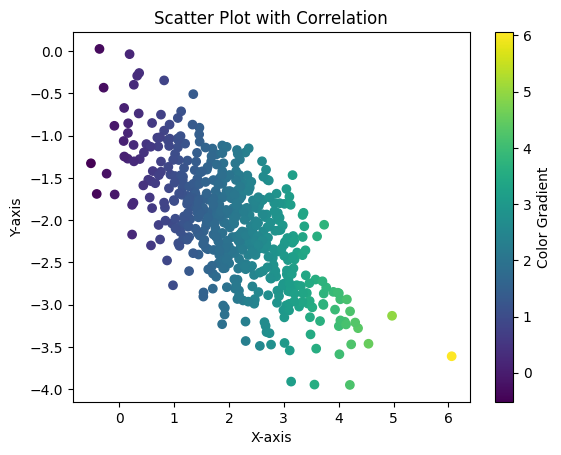

In [42]:
# Parameters
num_points = 500
mean_x, std_x = 2, 1  # Adjust these to control the x-values
mean_y, std_y = -1, 0.5  # Adjust these to control the y-values

# Generate random x and y values
x = np.random.normal(mean_x, std_x, num_points)
y = -0.5 * x + np.random.normal(mean_y, std_y, num_points)  # Adjust the relationship

z = torch.stack((torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) ,dim=1)
# Optional: Add a color gradient
colors = np.linspace(0, 1, num_points)

# Plot the result
plt.scatter(x, y, c=z[:, 0], cmap='viridis')
plt.colorbar(label='Color Gradient')
plt.title("Scatter Plot with Correlation")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [ ]:
def compute_loss(model, x_batch):
    x_batch.requires_grad_(True)
    g_x = model(x_batch)  # Forward pass
    # Compute Jacobian for each sample in the batch
    batch_size = x_batch.shape[0]
    log_det = torch.zeros(batch_size, device=x_batch.device)

    for i in range(batch_size):
        J = torch.autograd.functional.jacobian(lambda x: model(x.unsqueeze(0)), x_batch[i], create_graph=True)
        det = torch.det(J)
        log_det[i] = torch.log(det.abs() + 1e-6)  # Avoid log(0)

    # Gaussian log-likelihood
    log_p = -0.5 * ((g_x ** 2).sum(dim=1) - torch.log(torch.tensor(2 * torch.pi)))

    # Total loss
    loss = - (log_p + log_det).mean()
    return loss

In [49]:
model = M_MGN(input_dim=2, hidden_dim=3, num_modules=1).to('cuda')
print("Number of parameters in C-MGN", sum(p.size().numel() for p in model.parameters()))

Number of parameters in C-MGN 15


In [51]:
# Initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
batch_size= 25
# Training loop
for epoch in range(num_epochs):
  for i in range(0, len(z), batch_size):
      x_batch =  z[i:i + batch_size].to('cuda') # Load batches of data from p_X
      optimizer.zero_grad()
      loss = compute_loss(model, x_batch)
      loss.backward()
      optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 3.1208550930023193
Epoch 1, Loss: 2.8094303607940674
Epoch 2, Loss: 2.6532485485076904
Epoch 3, Loss: 2.574558734893799
Epoch 4, Loss: 2.5314459800720215
Epoch 5, Loss: 2.5040571689605713
Epoch 6, Loss: 2.483293294906616
Epoch 7, Loss: 2.4651145935058594
Epoch 8, Loss: 2.447873115539551
Epoch 9, Loss: 2.431027889251709
Epoch 10, Loss: 2.4145150184631348
Epoch 11, Loss: 2.39844012260437
Epoch 12, Loss: 2.3829381465911865
Epoch 13, Loss: 2.3681178092956543
Epoch 14, Loss: 2.3540475368499756
Epoch 15, Loss: 2.340761423110962
Epoch 16, Loss: 2.328263282775879
Epoch 17, Loss: 2.3165383338928223
Epoch 18, Loss: 2.3055593967437744
Epoch 19, Loss: 2.295290470123291
Epoch 20, Loss: 2.285691976547241
Epoch 21, Loss: 2.276721477508545
Epoch 22, Loss: 2.268336772918701
Epoch 23, Loss: 2.260495662689209
Epoch 24, Loss: 2.253157138824463
Epoch 25, Loss: 2.2462821006774902
Epoch 26, Loss: 2.239833116531372
Epoch 27, Loss: 2.2337746620178223
Epoch 28, Loss: 2.228074550628662
Epoch 29, L

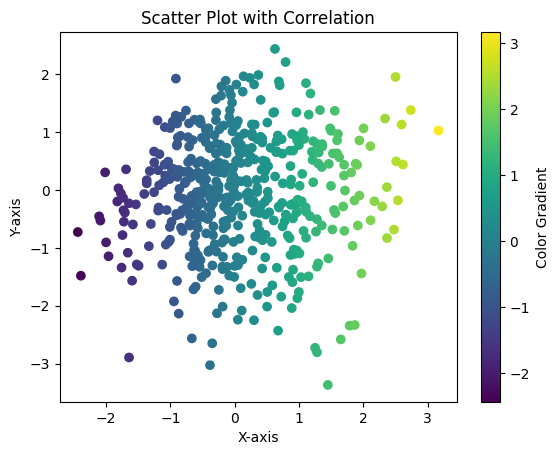

In [52]:
#  Pass the data through the model
model.eval()
output = model(z.to('cuda')).detach().cpu().numpy()

# Visualize the output
colors = np.linspace(0, 1, num_points)
plt.scatter(output[:, 0], output[:, 1], c=output[:, 0], cmap='viridis')
plt.colorbar(label='Color Gradient')
plt.title("Scatter Plot with Correlation")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


# Generate random values for tensor `s` using normal distribution
#s = torch.normal(mean=z.mean(), std=z.std(), size=z.size())

#plt.scatter(s[:, 0], s[:, 1])
plt.show()

### ICNNs:

In [53]:
class ICNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(ICNN, self).__init__()
        # Define ReLU activation
        self.relu = nn.ReLU()

        # Use nn.ModuleList for layers to ensure they are registered as model parameters
        self.modules_x = nn.ModuleList([nn.Linear(input_dim, hidden_dim, bias=True) for _ in range(num_layers)])
        self.modules_z = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim, bias=False) for _ in range(num_layers)])

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Initialize zl as a zero tensor with the same device as x
        zl = torch.zeros(x.shape[0], self.modules_x[0].out_features, device=x.device)
        for i in range(len(self.modules_x)):
            self.modules_z[i].weight.data.clamp_(min=0)
            zl = self.relu(self.modules_z[i](zl) + self.modules_x[i](x))  # Apply ReLU activation
        return zl

    def _initialize_weights(self):
        # Loop through all layers and apply Xavier initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)  # Apply Xavier uniform initialization
                if module.bias is not None:
                    init.zeros_(module.bias)  # Initialize biases to 0

In [ ]:
# Initialize the M-MGN model
input_dim = 2  # x is 2D
hidden_dim = 1  # Example hidden dimension
num_modules = 5  # Number of modules
model = ICNN(input_dim, hidden_dim, num_modules).to('cuda')

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_samples = 1_000_000
x = torch.rand(num_samples, 2)  # Shape: [num_samples, 2]
true_fx = f(x)

# Training loop
batch_size = 1024  # Example batch size
num_epochs = 30  # Number of epochs

for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Get batch of data
        x_batch = x[i:i + batch_size]
        true_fx_batch = true_fx[i:i + batch_size]

        # Forward pass
        pred_fx_batch = model(x_batch.to('cuda'))
        pred_gradient = 
        # Compute loss
        loss = compute_loss(pred_gradient.to('cuda'), true_fx_batch.unsqueeze(1).to('cuda'))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.09407000243663788
Epoch 2, Loss: 0.0412365086376667
Epoch 3, Loss: 0.032853372395038605
Epoch 4, Loss: 0.03106597438454628
Epoch 5, Loss: 0.03034294955432415
Epoch 6, Loss: 0.029815852642059326
Epoch 7, Loss: 0.029445268213748932
Epoch 8, Loss: 0.029046880081295967
Epoch 9, Loss: 0.028734780848026276
Epoch 10, Loss: 0.028472311794757843
Epoch 11, Loss: 0.028269747272133827
Epoch 12, Loss: 0.02819783240556717
Epoch 13, Loss: 0.028123749420046806
Epoch 14, Loss: 0.028101563453674316
Epoch 15, Loss: 0.02804848924279213
Epoch 16, Loss: 0.02806996740400791
Epoch 17, Loss: 0.028041183948516846
Epoch 18, Loss: 0.028040511533617973
Epoch 19, Loss: 0.02801504358649254
Epoch 20, Loss: 0.028035985305905342
Epoch 21, Loss: 0.028037497773766518
Epoch 22, Loss: 0.02803872339427471
Epoch 23, Loss: 0.02806553617119789
Epoch 24, Loss: 0.028045926243066788
Epoch 25, Loss: 0.02808264270424843
Epoch 26, Loss: 0.028063589707016945
Epoch 27, Loss: 0.02806844376027584
Epoch 28, Loss: 0.02808

In [72]:
def func(x):

    # Compute gradients
    outputs = model(x.squeeze(0))
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=x,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]  # Extract gradient tensor

    return grad

In [75]:
import torch
import torch.optim as optim

# Initialize the M-MGN model
input_dim = 2  # x is 2D
hidden_dim = 1  # Example hidden dimension
num_modules = 5  # Number of modules
model = ICNN(input_dim, hidden_dim, num_modules).to('cuda')

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x = z

# Training loop
batch_size = 25  # Example batch size
num_epochs = 100  # Number of epochs
num_samples = x.shape[0]
for epoch in range(num_epochs):
    for i in range(0, num_samples, batch_size):
        # Get batch of data
        x_batch = x[i:i + batch_size].to('cuda')
        x_batch.requires_grad = True
        # Forward pass
        pred_fx_batch = model(x_batch)
        
        # Compute gradient of the output w.r.t. inputs
        pred_gradient = torch.autograd.grad(
            outputs=pred_fx_batch,
            inputs=x_batch,
            grad_outputs=torch.ones_like(pred_fx_batch),  # Gradient of scalar w.r.t. vector
            create_graph=True
        )[0]  # Returns a tuple; take the first element for the gradient tensor

        # Compute loss
        loss = compute_loss(func, pred_gradient)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 17.43573570251465
Epoch 2, Loss: 17.400218963623047
Epoch 3, Loss: 17.297565460205078
Epoch 4, Loss: 17.20172882080078
Epoch 5, Loss: 17.112449645996094
Epoch 6, Loss: 17.028589248657227
Epoch 7, Loss: 16.94977378845215
Epoch 8, Loss: 16.875947952270508
Epoch 9, Loss: 16.806068420410156
Epoch 10, Loss: 16.74028968811035
Epoch 11, Loss: 16.67801284790039
Epoch 12, Loss: 16.618961334228516
Epoch 13, Loss: 16.589723587036133
Epoch 14, Loss: 16.557750701904297
Epoch 15, Loss: 16.52672004699707
Epoch 16, Loss: 16.496469497680664
Epoch 17, Loss: 16.46695899963379
Epoch 18, Loss: 16.43815803527832
Epoch 19, Loss: 16.410133361816406
Epoch 20, Loss: 16.3829345703125
Epoch 21, Loss: 16.35641860961914
Epoch 22, Loss: 16.33075714111328
Epoch 23, Loss: 16.3057918548584
Epoch 24, Loss: 16.281572341918945
Epoch 25, Loss: 16.258136749267578
Epoch 26, Loss: 16.23540687561035
Epoch 27, Loss: 16.21337127685547
Epoch 28, Loss: 16.014867782592773
Epoch 29, Loss: 16.171403884887695
Epoch 30, 

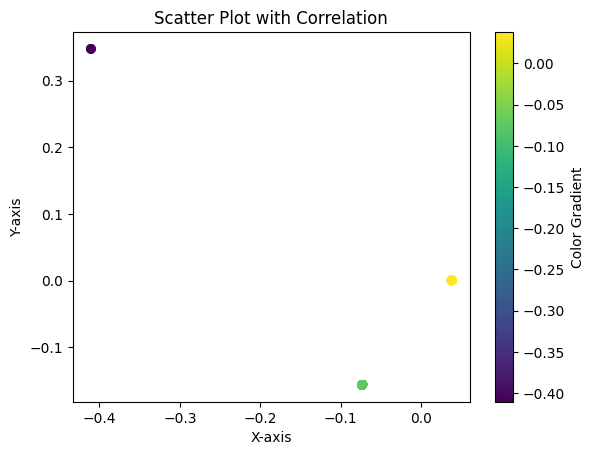

In [77]:
#  Pass the data through the model
#model.eval()
z.requires_grad = True
output = func(z.to('cuda')).detach().cpu().numpy()

# Visualize the output
colors = np.linspace(0, 1, num_points)
plt.scatter(output[:, 0], output[:, 1], c=output[:, 0], cmap='viridis')
plt.colorbar(label='Color Gradient')
plt.title("Scatter Plot with Correlation")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


# Generate random values for tensor `s` using normal distribution
#s = torch.normal(mean=z.mean(), std=z.std(), size=z.size())

#plt.scatter(s[:, 0], s[:, 1])
plt.show()